a).

Simulate the model and determine the flux control coefficients for each of the enzymes in the pathway

In [1]:
import numpy as np
from scipy.integrate import odeint

In [2]:
# Define parameters in a dictionary
params = {
    # METI parameters
    'v_MATI_max': 561,
    'K_MATI_m': 41,
    'K_MATI_i': 50,

    # MATIII parameters
    'v_MATIII_max': 22870,  # 22.87 mmol/hr/l
    'K_MATIII_m2': 21.1,

    # MET parameters
    'v_MET_max': 4544,
    'A_over_K_MET_m2': 0.1,

    # GNMT parameters
    'v_GNMT_max': 10600,  # 10.6 mmol/hr/l
    'K_GNMT_m': 4500,
    'K_GNMT_i': 20,

    # D parameters
    'alpha_d': 1333,

    # AHC parameters
    'K_AHC': 0.1,
    'Adenosine': 1,

    # Methionine concentration
    'Met': 48.5
}


In [3]:
# Define the differential equations for the pathway
def methionine_metabolism(y, t, params):
    AdoMet, AdoHcy = y

    #auxilliary variables
    K_MATIII_m1 = 20000/(1+ 5.7*(np.power(AdoMet/(AdoMet+600),2)))
    K_MET_m1 = 10 * (1 + AdoHcy/4)
    Hcy = AdoHcy*params['K_AHC']/params['Adenosine']


    v_MATI= params['v_MATI_max'] * (1/(1+ (params['K_MATI_m'] /params['Met'] )*(1+AdoMet/params['K_MATI_i'] ))) 
    v_MATIII = params['v_MATIII_max']  * (1/(1+ (K_MATIII_m1*params['K_MATIII_m2'] )/(np.power(params['Met'] ,2)+params['Met'] *params['K_MATIII_m2'] )))
    v_GNMT = params['v_GNMT_max']  * (1/(1+np.power(params['K_GNMT_m'] /AdoMet,2.3))) * (1/(1+AdoHcy/params['K_GNMT_i'] ))
    v_MET = params['v_MET_max']  * (1/(1+ K_MET_m1/AdoMet + 1/params['A_over_K_MET_m2']  + (1/params['A_over_K_MET_m2'])*(K_MET_m1/AdoMet)))
    V_D = params['alpha_d'] * Hcy;

    dAdoMetdt = (v_MATI + v_MATIII) - (v_GNMT+v_MET);
    dAdoHcydt = ((v_GNMT+v_MET) - V_D)/(1+params['K_AHC']/params['Adenosine']);

    return [dAdoMetdt, dAdoHcydt]

In [4]:
# Initial concentrations from Figure 5.10
initial_concentrations = {
    'AdoMet': 10,  # µM
    'AdoHcy': 10,  # µM
}

In [30]:
# Time points for simulation

#set simulation length
Tend=1000;

#initial concentrations
S0=[10,10];

time_points=np.linspace(0,Tend,1000000)

In [31]:
def model_simulation(parameters, initial_concentrations, time):
    y0 = [initial_concentrations['AdoMet'], initial_concentrations['AdoHcy']]
    results = odeint(methionine_metabolism, y0, time, args=(parameters,))
    return results

In [32]:
results = model_simulation(params, initial_concentrations, time_points)
# Extract results
AdoMet_conc = results[:, 0]
AdoHcy_conc = results[:, 1]

In [33]:
# Store results for further analysis
steady_state_AdoMet = AdoMet_conc[-1]
steady_state_AdoHcy = AdoHcy_conc[-1]

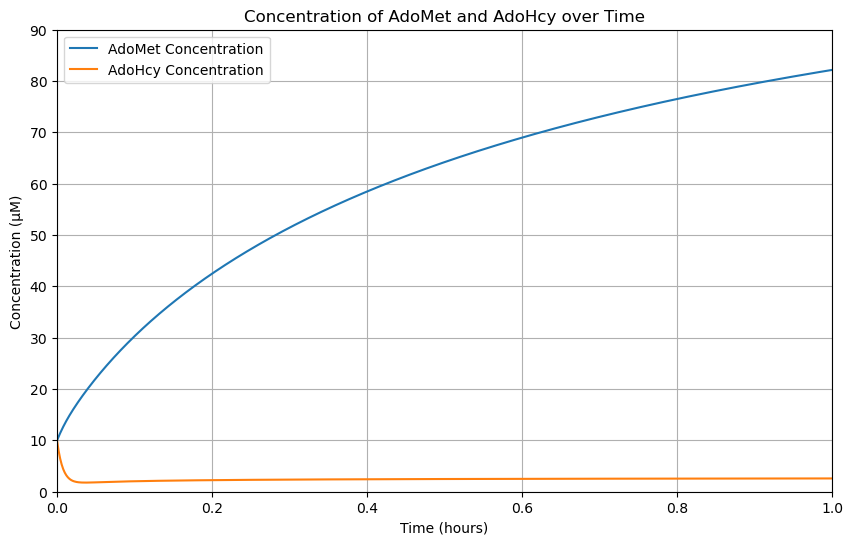

In [34]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time_points, AdoMet_conc, label='AdoMet Concentration')
plt.plot(time_points, AdoHcy_conc, label='AdoHcy Concentration')
plt.xlim(0, 1)
plt.ylim(0, 90)
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (µM)')
plt.title('Concentration of AdoMet and AdoHcy over Time')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
# Define flux equations for each enzyme at steady state
def calculate_fluxes(params, AdoMet, AdoHcy):
    K_MATIII_m1 = 20000/(1+ 5.7*(np.power(AdoMet/(AdoMet+600),2)))
    K_MET_m1 = 10 * (1 + AdoHcy/4)
    Hcy = AdoHcy*params['K_AHC']/params['Adenosine']


    v_MATI= params['v_MATI_max'] * (1/(1+ (params['K_MATI_m'] /params['Met'] )*(1+AdoMet/params['K_MATI_i'] ))) 
    v_MATIII = params['v_MATIII_max']  * (1/(1+ (K_MATIII_m1*params['K_MATIII_m2'] )/(np.power(params['Met'] ,2)+params['Met'] *params['K_MATIII_m2'] )))
    v_GNMT = params['v_GNMT_max']  * (1/(1+np.power(params['K_GNMT_m'] /AdoMet,2.3))) * (1/(1+AdoHcy/params['K_GNMT_i'] ))
    v_MET = params['v_MET_max']  * (1/(1+ K_MET_m1/AdoMet + 1/params['A_over_K_MET_m2']  + (1/params['A_over_K_MET_m2'])*(K_MET_m1/AdoMet)))
    V_D = params['alpha_d'] * Hcy;

    return v_MATI, v_MATIII, v_GNMT, v_MET, V_D

In [36]:
# Calculate fluxes at steady state
steady_fluxes = calculate_fluxes(params, steady_state_AdoMet, steady_state_AdoHcy)

In [37]:
steady_state_AdoMet, steady_state_AdoHcy

(106.4180532504632, 2.690766428867957)

In [38]:
steady_fluxes

(153.9266148522228,
 204.75255011587586,
 1.6988465456307134,
 356.980318422468,
 358.6791649680987)

In [39]:
steady_fluxes[0] + steady_fluxes[1], steady_fluxes[2] + steady_fluxes[3], steady_fluxes[4]

(358.6791649680987, 358.6791649680987, 358.6791649680987)

In [40]:
# Define control coefficient calculation function
def flux_control_coefficients(params, original_pathway_flux, AdoMet, AdoHcy):
    
    control_coefficients = []

    # Partial derivatives approximated by small perturbations
    perturbation = 0.05

    # perturbed_fluxes = {
    #     enzyme: calculate_fluxes({**params, enzyme: params[enzyme] * (1 + perturbation)}, AdoMet, AdoHcy)
    #     for enzyme in ['V_MATI_max', 'V_MATIII_max', 'V_GNMT_max', 'V_MET_max', 'alpha_d']
    # }

    # enzymes = ['v_MATI_max', 'V_MATIII_max', 'V_GNMT_max', 'V_MET_max']
    enzymes = ['v_MATI_max', 'v_MATIII_max', 'v_GNMT_max', 'v_MET_max', 'alpha_d']

    for i in range(len(enzymes)):
        simulation_results = model_simulation({**params, enzymes[i]: params[enzymes[i]] * (1 + perturbation)}, initial_concentrations, time_points)
        AdoMet_ss = simulation_results[-1, 0]
        AdoHcy_ss = simulation_results[-1, 1]
        perturbed_fluxes = calculate_fluxes({**params, enzymes[i]: params[enzymes[i]] * (1 + perturbation)}, AdoMet_ss, AdoHcy_ss)
        print(perturbed_fluxes[0]+perturbed_fluxes[1], perturbed_fluxes[2]+perturbed_fluxes[3], perturbed_fluxes[4])
        print(original_pathway_flux)

        perturbed_pathway_flux = perturbed_fluxes[0] + perturbed_fluxes[1] 
        coeff = (perturbed_pathway_flux - original_pathway_flux) * (params[enzymes[i]] / (original_pathway_flux * perturbation * params[enzymes[i]]))
        control_coefficients.append(coeff)


    # Calculate flux control coefficients
    # control_coefficients = {
    #     enzyme: ((perturbed_fluxes[enzyme][0] - V_MATI) / (V_MATI * perturbation))
    #     for enzyme in perturbed_fluxes
    # }

    # control_coefficients = {}
    # for ind in range(len(enzymes)):
    #     enzyme = list(perturbed_pathway_flux.keys())[ind]
    #     control_coefficients[enzyme] = (perturbed_pathway_flux[enzyme] - original_pathway_flux) / (params[enzyme] / (original_pathway_flux * perturbation * params[enzyme]))
    
    return control_coefficients

In [41]:
# Calculate the flux control coefficients
original_pathway_flux = steady_fluxes[-1]
flux_control_coeffs = flux_control_coefficients(params, original_pathway_flux, steady_state_AdoMet, steady_state_AdoHcy)

363.0309201635296 363.0309201635295 363.0309201635296
358.6791649680987
364.99190168097186 364.9919016809734 364.9919016809735
358.6791649680987
358.7132131466247 358.71321314662475 358.7132131466247
358.6791649680987
365.9361470856909 365.93614708569095 365.9361470856909
358.6791649680987
359.0612490699055 359.0612490699054 359.06124906990544
358.6791649680987


In [42]:
print(flux_control_coeffs, sum(flux_control_coeffs))

[0.24265447343828475, 0.3519990749077737, 0.0018985311582865431, 0.4046503296748583, 0.021305062525212123] 1.0225074717044154


should i include the coeff on a_d, if not the sum doesnt add up exactly to 1. 
played with the perterbed distance, the sum is changing arond 1? 

(b). 

In [43]:
params

{'v_MATI_max': 561,
 'K_MATI_m': 41,
 'K_MATI_i': 50,
 'v_MATIII_max': 22870,
 'K_MATIII_m2': 21.1,
 'v_MET_max': 4544,
 'A_over_K_MET_m2': 0.1,
 'v_GNMT_max': 10600,
 'K_GNMT_m': 4500,
 'K_GNMT_i': 20,
 'alpha_d': 1333,
 'K_AHC': 0.1,
 'Adenosine': 1,
 'Met': 48.5}

In [44]:
{**params, 'Met': 51}

{'v_MATI_max': 561,
 'K_MATI_m': 41,
 'K_MATI_i': 50,
 'v_MATIII_max': 22870,
 'K_MATIII_m2': 21.1,
 'v_MET_max': 4544,
 'A_over_K_MET_m2': 0.1,
 'v_GNMT_max': 10600,
 'K_GNMT_m': 4500,
 'K_GNMT_i': 20,
 'alpha_d': 1333,
 'K_AHC': 0.1,
 'Adenosine': 1,
 'Met': 51}

In [45]:
simulation_results_b = model_simulation({**params, 'Met': 51}, initial_concentrations, time_points)
AdoMet_ss_b = simulation_results_b[-1, 0]
AdoHcy_ss_b = simulation_results_b[-1, 1]
fluxes_b = calculate_fluxes({**params, 'Met': 51}, AdoMet_ss_b, AdoHcy_ss_b)
print(fluxes_b[0]+fluxes_b[1], fluxes_b[2]+fluxes_b[3], fluxes_b[4])

375.1521115044851 375.15211150449056 375.1521115044905


In [46]:
steady_fluxes

(153.9266148522228,
 204.75255011587586,
 1.6988465456307134,
 356.980318422468,
 358.6791649680987)

In [47]:
fluxes_b

(132.29987185439896,
 242.85223965008612,
 3.808385951027607,
 371.34372555346295,
 375.1521115044905)

In [48]:
np.array(list(fluxes_b)) - np.array(list(steady_fluxes))

array([-21.626743  ,  38.09968953,   2.10953941,  14.36340713,
        16.47294654])

this doesnt align with the question statement, MATIII and GNMT should have a dramatic increase, and MET have a relatively small increase. 

(c). 

In [24]:
params_c = {**parameters, 'Met': 51}
params_c

NameError: name 'parameters' is not defined

In [179]:
initial_concentrations_c = {
    'AdoMet': 400,  # µM
    'AdoHcy': 2,  # µM
}

In [180]:
simulation_results_c = model_simulation(params_c, initial_concentrations_c, time_points)
AdoMet_ss_c = simulation_results_c[-1, 0]
AdoHcy_ss_c = simulation_results_c[-1, 1]

In [181]:
simulation_results_c

array([[400.        ,   2.        ],
       [400.00834067,   2.14379646],
       [400.01722897,   2.2707164 ],
       ...,
       [975.1016532 ,   4.87293448],
       [975.1016532 ,   4.87293448],
       [975.1016532 ,   4.87293448]])

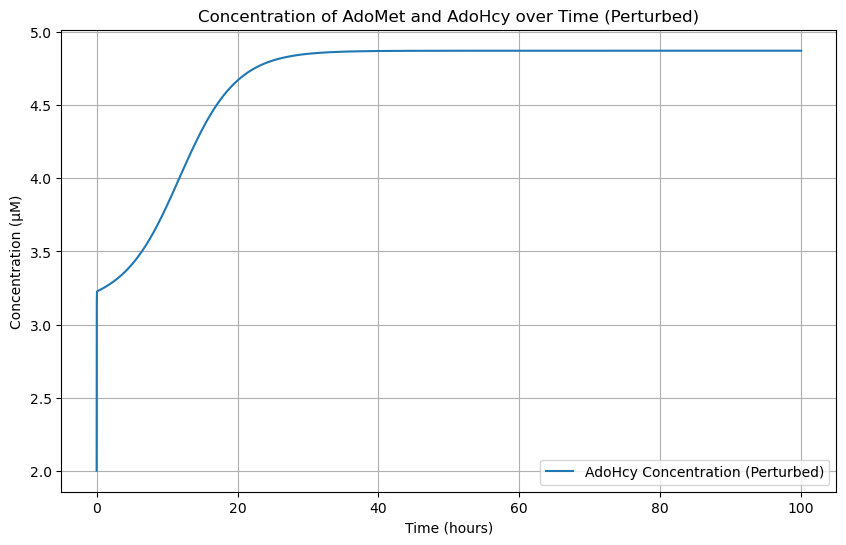

In [192]:
plt.figure(figsize=(10, 6))
plt.plot(time_points, simulation_results_c[:, 0], label='AdoMet Concentration (Perturbed)')
plt.plot(time_points, simulation_results_c[:, 1], label='AdoHcy Concentration (Perturbed)')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (µM)')
plt.title('Concentration of AdoMet and AdoHcy over Time (Perturbed)')
plt.legend()
plt.grid(True)
plt.show()

In [189]:
simulation_results_c_perturbed = model_simulation({**params_c, 'V_MATIII_max': parameters['V_MATIII_max']*1.1}, initial_concentrations_c, time_points)
simulation_results_c_perturbed

array([[ 400.        ,    2.        ],
       [ 400.04582259,    2.14380048],
       [ 400.09220089,    2.27073182],
       ...,
       [1196.43263704,    5.82909493],
       [1196.43263704,    5.82909493],
       [1196.43263704,    5.82909493]])

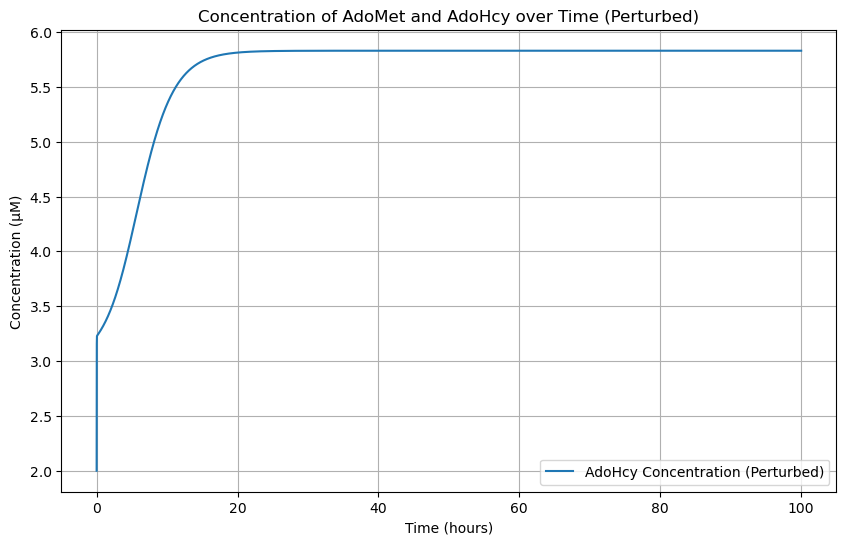

In [191]:
plt.figure(figsize=(10, 6))
# plt.plot(time_points, simulation_results_c_perturbed[:, 0], label='AdoMet Concentration (Perturbed)')
plt.plot(time_points, simulation_results_c_perturbed[:, 1], label='AdoHcy Concentration (Perturbed)')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (µM)')
plt.title('Concentration of AdoMet and AdoHcy over Time (Perturbed)')
plt.legend()
plt.grid(True)
plt.show()

chose i.c. between the stable and unstable fixed point, goes to the stable f.p. on the left, but when perturbed more than 15 % still goes to the same fixed point